importation des bibliothèque nécessaire

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Pour la modélisation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Modèles
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier  # Assurez-vous d'avoir installé catboost (pip install catboost)
from sklearn.svm import SVC

# Pipeline et normalisation pour SVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

PARTIE 1 : CHARGEMENT & IMPUTATION DES DONNEES

In [28]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv"
data = pd.read_csv(url, header=0)
data = data.replace('?', pd.NA) # Replace '?' with NA
data = data.apply(pd.to_numeric, errors='coerce') # Convert to numeric values
print(data.head())

   Age  Number of sexual partners  First sexual intercourse  \
0   18                        4.0                      15.0   
1   15                        1.0                      14.0   
2   34                        1.0                       NaN   
3   52                        5.0                      16.0   
4   46                        3.0                      21.0   

   Num of pregnancies  Smokes  Smokes (years)  Smokes (packs/year)  \
0                 1.0     0.0             0.0                  0.0   
1                 1.0     0.0             0.0                  0.0   
2                 1.0     0.0             0.0                  0.0   
3                 4.0     1.0            37.0                 37.0   
4                 4.0     0.0             0.0                  0.0   

   Hormonal Contraceptives  Hormonal Contraceptives (years)  IUD  ...  \
0                      0.0                              0.0  0.0  ...   
1                      0.0                            

Suppression des colonnes avec plus de 50% de valeurs manquantes

In [29]:
threshold = len(data) * 0.5  
data_cleaned = data.dropna(thresh=threshold, axis=1)
data_cleaned = data_cleaned.copy()  # Pour éviter les avertissements

# Conversion de "Biopsy" en entier
data_cleaned.loc[:, "Biopsy"] = data_cleaned["Biopsy"].astype(int)
# Liste des colonnes avant et après traitement
columns_before = data.columns
columns_after = data_cleaned.columns

# Colonnes supprimées
removed_columns = list(set(columns_before) - set(columns_after))
print("Colonnes supprimées : ", removed_columns)


Colonnes supprimées :  ['STDs: Time since last diagnosis', 'STDs: Time since first diagnosis']


Conversion explicite en float pour les colonnes suspectées

In [30]:
# Liste des colonnes supposées numériques (pour conversion explicite)
numeric_cols_suspected = [
    "Age",
    "Number of sexual partners",
    "First sexual intercourse",
    "Num of pregnancies",
    "Smokes",
    "Smokes (years)",
    "Smokes (packs/year)",
    "Hormonal Contraceptives (years)",
    "IUD (years)",
    "STDs",
    "STDs (number)",
    "STDs: Number of diagnosis",
    "STDs: Time since first diagnosis",
    "STDs: Time since last diagnosis"
]
# Conversion explicite en float pour les colonnes suspectées
for col in numeric_cols_suspected:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
print(data[numeric_cols_suspected].dtypes)

Age                                   int64
Number of sexual partners           float64
First sexual intercourse            float64
Num of pregnancies                  float64
Smokes                              float64
Smokes (years)                      float64
Smokes (packs/year)                 float64
Hormonal Contraceptives (years)     float64
IUD (years)                         float64
STDs                                float64
STDs (number)                       float64
STDs: Number of diagnosis             int64
STDs: Time since first diagnosis    float64
STDs: Time since last diagnosis     float64
dtype: object


Transformation log et winsorisation pour réduire l'asymétrie et limiter les outliers

In [31]:
columns_to_treat = ['Age', 'First sexual intercourse']
for col in columns_to_treat:
    skew_val = data_cleaned[col].skew()
    data_cleaned[col + '_log'] = np.log1p(data_cleaned[col])
    winsorized_values = np.array(winsorize(data_cleaned[col + '_log'], limits=(0.05, 0.05)))
    data_cleaned[col + '_log_winsorized'] = winsorized_values
    print(f"Colonne '{col}' (skewness = {skew_val:.2f}): transformation log et winsorisation appliquées.")

Colonne 'Age' (skewness = 1.39): transformation log et winsorisation appliquées.
Colonne 'First sexual intercourse' (skewness = 1.56): transformation log et winsorisation appliquées.


Imputation des valeurs manquantes sur l'original par la valeur médiane (hors cible)

In [33]:
for col in data.columns:
    if col == "Biopsy":
        continue
    if data[col].dtype in [np.float64, np.int64]:
        data[col].fillna(data[col].median(), inplace=True)
    else:
        mode_val = data[col].mode(dropna=True)
        if not mode_val.empty:
            data[col].fillna(mode_val[0], inplace=True)
        else:
            data[col].fillna("Inconnu", inplace=True)
# Vérifier les valeurs manquantes après imputation
missing_values = data.isnull().sum()
print("Valeurs manquantes après imputation :")
print(missing_values)


Valeurs manquantes après imputation :
Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
ST

PARTIE 2 : PRÉPARATION DES DONNÉES POUR LA MODÉLISATION  

Cette étape consiste à préparer les données pour la modélisation. Les données doivent être nettoyées, traitées et organisées de manière à ce qu’elles soient équilibreés et représentatives de la population cible.
Pour cela on a utiliser la méthode smote qui est une méthode de suramplification de données minoritaires. Elle consiste à créer de nouvelles instances de données minoritaires en fonction des données existantes.

In [38]:
# Séparation des features (X) et de la cible (y) à partir de data_cleaned
X = data_cleaned.drop(columns=['Biopsy'])
y = data_cleaned['Biopsy']

# Division en ensembles d'entraînement et de test (sans stratification ici pour SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputation des valeurs manquantes dans X_train avec la médiane (pour SMOTE)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)

# Application de SMOTE sur l'ensemble d'entraînement imputé
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)
nouveau_data = pd.DataFrame(X_train_res, columns=X.columns)
nouveau_data['Biopsy'] = y_train_res
print(nouveau_data.columns)
print("\nRépartition des classes après SMOTE:")
print(pd.Series(y_train_res).value_counts())

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Age_log', 'Age_log_winsorized',
       'First sexual intercourse_log',
       'First sexual intercourse_log_winsorized', 'Biopsy'],
      dtype='object')

Répartition des classes après SMOTE:
Biopsy
0    642
1    642
Name: count, dtype: int64


PARTIE 3 : RÉDUCTION DE LA MULTICOLLINÉARITÉ  

La multicollinéarité est un problème courant dans les analyses des données. Elle se produit lorsque plusieurs variables sont fortement corrélées entre elles, ce qui peut entraîner des problèmes de stabilité et de précision dans les modèles de régression. Pour cela , nous allons utiliser la méthode de sélection de variables par la méthode de Ridge Regression. 

Colonnes supprimées : ['STDs (number)', 'STDs:condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs: Number of diagnosis', 'Dx:HPV', 'Age_log_winsorized', 'First sexual intercourse_log_winsorized', 'Biopsy']
Dimensions du DataFrame réduit : (1284, 29)


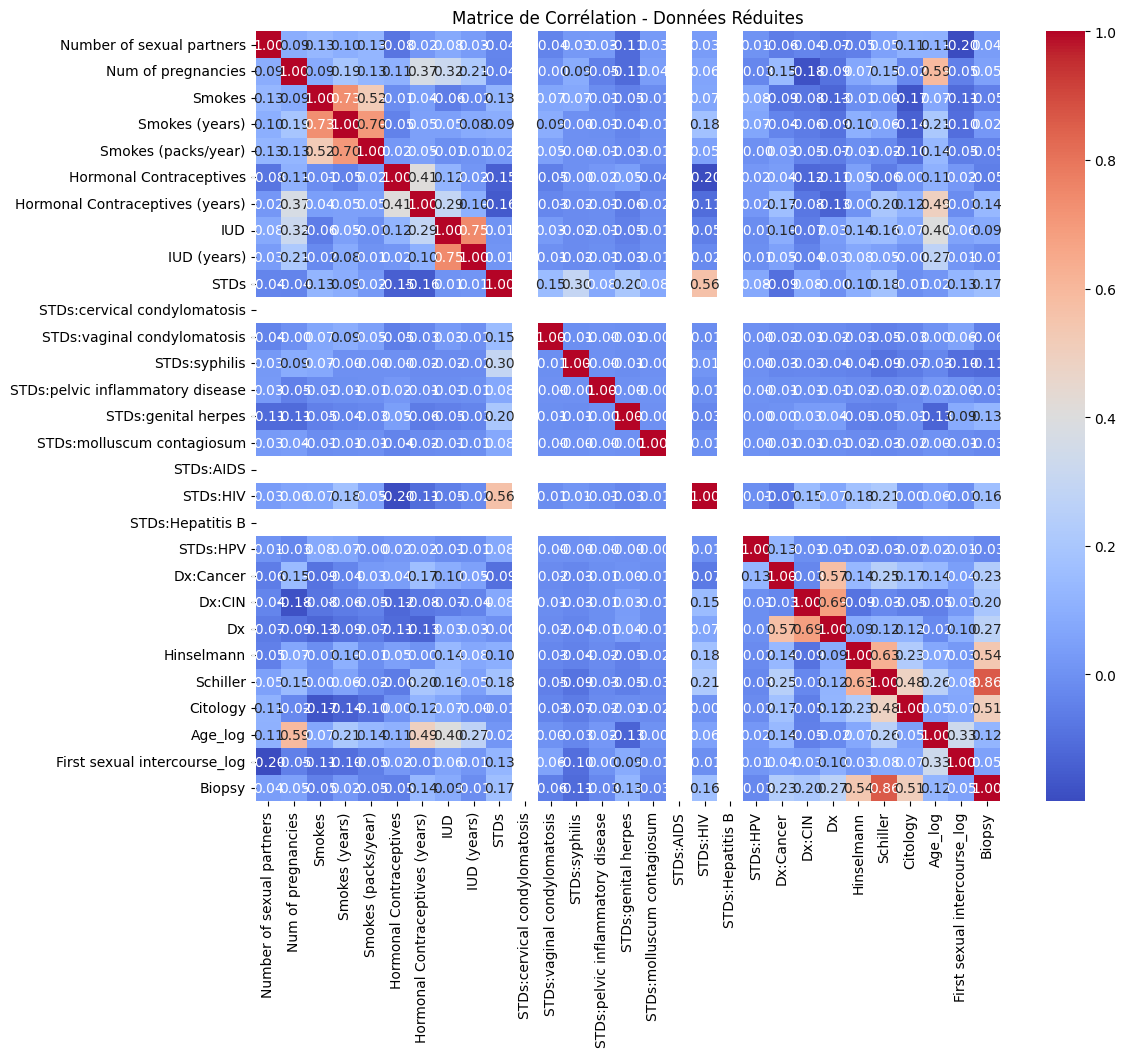

Index(['Number of sexual partners', 'Num of pregnancies', 'Smokes',
       'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:syphilis', 'STDs:pelvic inflammatory disease',
       'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS',
       'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'Dx:Cancer', 'Dx:CIN', 'Dx',
       'Hinselmann', 'Schiller', 'Citology', 'Age_log',
       'First sexual intercourse_log', 'Biopsy'],
      dtype='object')


In [40]:
# Ajout de la colonne 'Biopsy' au DataFrame 'data_final'
data_final = nouveau_data.copy()

# Retirer les colonnes non nécessaires
colonnes_a_exclure = ['Age', 'First sexual intercourse']
data_final = data_final.drop(columns=colonnes_a_exclure)

# Calcul de la matrice de corrélation en valeurs absolues
corr_matrix = data_final.corr().abs()

# Extraction de la partie supérieure triangulaire pour éviter les doublons
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identification des colonnes à supprimer si corrélation > 0.8 avec au moins une autre variable
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]

# Suppression des colonnes identifiées
data_final_reduced = data_final.drop(columns=to_drop)

# Ajout de la colonne 'Biopsy' au DataFrame réduit
data_final_reduced['Biopsy'] = data_final['Biopsy']

# Affichage des colonnes supprimées et des dimensions du DataFrame réduit
print("Colonnes supprimées :", to_drop)
print("Dimensions du DataFrame réduit :", data_final_reduced.shape)

# Affichage de la matrice de corrélation du DataFrame réduit via une heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data_final_reduced.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de Corrélation - Données Réduites")
plt.show()

# Affichage des colonnes du DataFrame réduit
print(data_final_reduced.columns)

In [41]:
print(data_final_reduced['Biopsy'].value_counts())

Biopsy
0    642
1    642
Name: count, dtype: int64


PARTIE 4 : ANALYSE EXPLORATOIRE DES DONNÉES (EDA)

In [42]:
print("Aperçu du dataset (5 premières lignes) :")
print(data_final_reduced.head())

print("\nDimensions (lignes, colonnes) :", data_final_reduced.shape)
print("\nInformations sur les colonnes :")
data_final_reduced.info()

print("\nStatistiques descriptives (variables numériques) :")
print(data_final_reduced.describe())

print("\nValeurs manquantes par colonne après imputation :")
print(data_final_reduced.isnull().sum())

# Vérification de la cible
target_col = 'Biopsy'
if target_col in data_final_reduced.columns:
    print("\nRépartition de la cible :")
    print(data_final_reduced[target_col].value_counts())
    print(data_final_reduced[target_col].value_counts(normalize=True) * 100)
else:
    print(f"\nATTENTION : la colonne '{target_col}' n'existe pas.")

Aperçu du dataset (5 premières lignes) :
   Number of sexual partners  Num of pregnancies  Smokes  Smokes (years)  \
0                        1.0                 3.0     0.0             0.0   
1                        2.0                 4.0     0.0             0.0   
2                        4.0                 2.0     1.0            11.0   
3                        1.0                 2.0     0.0             0.0   
4                        5.0                 4.0     0.0             0.0   

   Smokes (packs/year)  Hormonal Contraceptives  \
0                 0.00                      1.0   
1                 0.00                      1.0   
2                 2.75                      1.0   
3                 0.00                      1.0   
4                 0.00                      0.0   

   Hormonal Contraceptives (years)  IUD  IUD (years)  STDs  ...  STDs:HPV  \
0                              2.0  1.0          7.0   0.0  ...       0.0   
1                              2.0  0.0  

Partie 5 : optimisation de la mémoire 

In [45]:
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2  # Taille initiale en MB
    print(f'Mémoire avant optimisation : {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != 'object':  # Pour les colonnes numériques
            c_min = df[col].min()
            c_max = df[col].max()

            # Conversion des types int en fonction de la plage des valeurs
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            # Conversion des types float en fonction de la plage des valeurs
            else:
                if c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

        else:  # Pour les colonnes 'object', on les convertit en 'category' si possible
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # Taille après optimisation
    print(f'Mémoire après optimisation : {end_mem:.2f} MB')
    print(f'Reduction de mémoire : {100 * (start_mem - end_mem) / start_mem:.2f}%')
    
    return df

# Exemple d'utilisation de la fonction sur votre DataFrame 'data_final_reduced'
data_final_reduced_optimized = reduce_memory_usage(data_final_reduced)


Mémoire avant optimisation : 0.28 MB
Mémoire après optimisation : 0.14 MB
Reduction de mémoire : 51.27%


PARTIE 5 : MODÉLISATION ET ÉVALUATION DES MODÈLES

In [46]:
if target_col not in data_final_reduced_optimized.columns:
    print("Impossible de procéder à la modélisation : cible introuvable.")
    import sys
    sys.exit()

# Séparation des features et de la cible pour la modélisation
X = data_final_reduced_optimized.drop(columns=[target_col])
y = data_final_reduced_optimized[target_col].astype(int)

# On ne garde que les variables numériques
X = X.select_dtypes(include=[np.number])

# Division en ensembles d'entraînement et de test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model_results = []

# -------------------
# Random Forest
# -------------------
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'class_weight': ['balanced']
}
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='f1')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
rf_preds = rf_best.predict(X_test)
rf_f1 = f1_score(y_test, rf_preds)
model_results.append({'Model': 'RandomForest', 'F1-score': rf_f1})

# -------------------
# XGBoost
# -------------------
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'scale_pos_weight': [1, 3]
}
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='f1')
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
xgb_preds = xgb_best.predict(X_test)
xgb_f1 = f1_score(y_test, xgb_preds)
model_results.append({'Model': 'XGBoost', 'F1-score': xgb_f1})

# -------------------
# CatBoost Classifier
# -------------------
cat_params = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 6]
}
cat_model = CatBoostClassifier(random_state=42, verbose=0)
cat_grid = GridSearchCV(cat_model, cat_params, cv=5, scoring='f1')
cat_grid.fit(X_train, y_train)
cat_best = cat_grid.best_estimator_
cat_preds = cat_best.predict(X_test)
cat_f1 = f1_score(y_test, cat_preds)
model_results.append({'Model': 'CatBoost', 'F1-score': cat_f1})

# -------------------
# SVM avec Pipeline (imputation + scaling + SVC)
# -------------------
svm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True, random_state=42))
])
svm_params = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__class_weight': ['balanced']
}
svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5, scoring='f1')
svm_grid.fit(X_train, y_train)
svm_best = svm_grid.best_estimator_
svm_preds = svm_best.predict(X_test)
svm_f1 = f1_score(y_test, svm_preds)
model_results.append({'Model': 'SVM', 'F1-score': svm_f1})
models = {
    'RandomForest': rf_best,
    'XGBoost': xgb_best,
    'CatBoost': cat_best,
    'SVM': svm_best
}

results_metrics = []

for name, model in models.items():
    # Prédictions de classes
    y_pred = model.predict(X_test)
    # Calcul des probabilités pour le ROC-AUC (selon méthode disponible)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = y_pred  # solution de secours
    roc_auc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    
    results_metrics.append({
        "Model": name,
        "ROC-AUC": roc_auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    })

results_metrics_df = pd.DataFrame(results_metrics)
print("\nÉvaluation des modèles :")
print(results_metrics_df)


Évaluation des modèles :
          Model   ROC-AUC  Accuracy  Precision  Recall  F1-score
0  RandomForest  0.997699  0.988327   0.977099     1.0  0.988417
1       XGBoost  0.996487  0.988327   0.977099     1.0  0.988417
2      CatBoost  0.991945  0.988327   0.977099     1.0  0.988417
3           SVM  0.992006  0.984436   0.969697     1.0  0.984615


Donc on va choisir le modéle RandomForest pour la prédiction de la variable cible. Parcqu'il avait le meilleure score de ROC-AUC